# Extreme Flux conservation
This notebook was modified from the original GitHub issue https://github.com/DragonflyTelescope/dfreproject/issues/27.

In [1]:
import pytest
import numpy as np
import torch
from astropy.wcs import WCS
from astropy.io import fits
import os
import tempfile
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

We are first going to create a relatively extreme SIP distortion on a simple grid with a basic Gaussian feature to test the flux conservation implementation.

In [30]:
def create_wcs_with_sip(degree=3):
    """
    Create a WCS object with SIP distortion coefficients.

    Parameters:
    -----------
    degree : int, optional
        Degree of the SIP polynomial. Default is 3.

    Returns:
    --------
    astropy.wcs.WCS
        WCS object with SIP distortion
    """
    # Create base WCS header
    header = {
        'CTYPE1': 'RA---TAN-SIP',
        'CTYPE2': 'DEC--TAN-SIP',
        'CRPIX1': 100.0,
        'CRPIX2': 100.0,
        'CRVAL1': 150.0,
        'CRVAL2': 30.0,
        'CDELT1': -0.002,
        'CDELT2': 0.002,
        'PC1_1': 1.0,
        'PC1_2': 0.0,
        'PC2_1': 0.0,
        'PC2_2': 1.0,
        # Add SIP header keywords
        'A_ORDER': degree,
        'B_ORDER': degree,
        'AP_ORDER': degree,
        'BP_ORDER': degree,
    }

    # Add SIP coefficients
    # These are arbitrary small values for testing
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            if i + j > 0:  # Skip the constant term
                header[f'A_{i}_{j}'] = 0.003 * i * j
                header[f'B_{i}_{j}'] = -0.003 * i * j
                # Add inverse coefficients
                header[f'AP_{i}_{j}'] = -0.003 * i * j
                header[f'BP_{i}_{j}'] = 0.003 * i * j

    return WCS(header, relax=True)

def simple_wcs():
    """Fixture providing a simple TAN projection WCS."""
    header = {
        'CTYPE1': 'RA---TAN',
        'CTYPE2': 'DEC--TAN',
        'CRPIX1': 100.0,
        'CRPIX2': 100.0,
        'CRVAL1': 150.0,
        'CRVAL2': 30.0,
        'CDELT1': -0.001,
        'CDELT2': 0.001,
        'PC1_1': 1.0,
        'PC1_2': 0.0,
        'PC2_1': 0.0,
        'PC2_2': 1.0,
    }
    return WCS(header)

def sip_wcs():
    """Fixture providing a WCS with SIP distortion."""
    return create_wcs_with_sip(degree=2)

temp_dir = tempfile.mkdtemp()

def source_fits_file():
    """Create a source FITS file for testing."""
    import numpy as np

    # Create test data - a gradient pattern
    y, x = np.mgrid[0:200, 0:200]
    data = 100.0 * np.exp(-((x - 100) ** 2 + (y - 100) ** 2) / 1000.0)

    # Ensure data has native byte order
    data = np.asarray(data, dtype=np.float32).copy()

    # Create the file
    filename = os.path.join(temp_dir, "source.fits")
    create_test_fits_file(
        wcs_header=simple_wcs().to_header(relax=True),
        data=data,
        filename=filename
    )
    return filename

def target_fits_file():
    """Create a target FITS file for testing."""
    # Create a FITS file with target WCS but empty data
    import numpy as np
    data = np.zeros((200, 200), dtype=np.float32)
    # Ensure data has native byte order
    data = np.asarray(data, dtype=np.float32).copy()
    # Create the file
    filename = os.path.join(temp_dir, "target.fits")
    create_test_fits_file(
        wcs_header=sip_wcs().to_header(relax=True),
        data=data,
        filename=filename
    )
    return filename


def create_test_fits_file(wcs_header=None, data=None, filename=None):
    """
    Create a temporary FITS file for testing.

    Parameters:
    -----------
    wcs_header : dict, optional
        WCS header information to include
    data : numpy.ndarray, optional
        Image data. If None, creates a 200x200 empty array
    filename : str, optional
        Output filename. If None, creates a temporary file

    Returns:
    --------
    str
        Path to the created FITS file
    """
    # Create default data if not provided
    if data is None:
        data = np.zeros((200, 200), dtype=np.float32)

    # Create default WCS header if not provided
    if wcs_header is None:
        wcs_header = {
            'CTYPE1': 'RA---TAN',
            'CTYPE2': 'DEC--TAN',
            'CRPIX1': 100.0,
            'CRPIX2': 100.0,
            'CRVAL1': 150.0,
            'CRVAL2': 30.0,
            'CDELT1': -0.001,
            'CDELT2': 0.001,
            'PC1_1': 1.0,
            'PC1_2': 0.0,
            'PC2_1': 0.0,
            'PC2_2': 1.0,
        }

    # Create a temporary file if no filename is provided
    if filename is None:
        temp_file = tempfile.NamedTemporaryFile(suffix='.fits', delete=False)
        filename = temp_file.name
        temp_file.close()

    # Create HDU with data and header
    primary_hdu = fits.PrimaryHDU(data=data)

    # Add WCS headers
    for key, value in wcs_header.items():
        primary_hdu.header[key] = value

    # Write to file and close
    hdul = fits.HDUList([primary_hdu])
    hdul.writeto(filename, overwrite=True)
    hdul.close()

    return filename

In [31]:
source_hdu = fits.open(source_fits_file())[0]
target_hdu = fits.open(target_fits_file())[0]




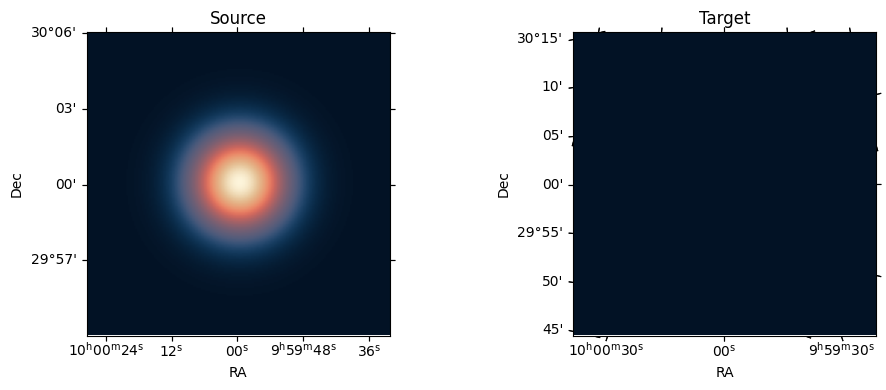

In [32]:
# Make WCS objects
wcs_source = WCS(source_hdu.header)
wcs_target = WCS(target_hdu.header)

# Create two subplots, each with its own WCS projection
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 4),
    subplot_kw={'projection': wcs_source}  # default for first one
)

# Matplotlib reuses subplot_kw for *all* axes, so we’ll override the second manually
axs = axs.ravel()  # flatten in case it's a 2D array of axes

# First image with source WCS
axs[0].imshow(source_hdu.data, origin="lower", cmap=cmc.lipari)
axs[0].set_xlabel("RA")
axs[0].set_ylabel("Dec")
axs[0].set_title("Source")

# Second image with target WCS (must reset projection!)
# easiest: use fig.add_subplot directly
fig.delaxes(axs[1])  # remove placeholder axes
axs[1] = fig.add_subplot(122, projection=wcs_target)
axs[1].imshow(target_hdu.data, origin="lower", cmap=cmc.lipari)
axs[1].set_xlabel("RA")
axs[1].set_ylabel("Dec")
axs[1].set_title("Target")

plt.tight_layout()
plt.show()

We now will apply the reprojection

In [33]:
# Import the Reproject class
from dfreproject.reproject import Reproject

# Create actual instance
reproject = Reproject([source_hdu], WCS(target_hdu.header, relax=True), shape_out=target_hdu.data.shape, conserve_flux=True, compute_jacobian=True, device='cpu')

result = reproject.interpolate_source_image(interpolation_mode="bilinear")

True True


In [34]:
result.data.cpu().shape

torch.Size([200, 200])

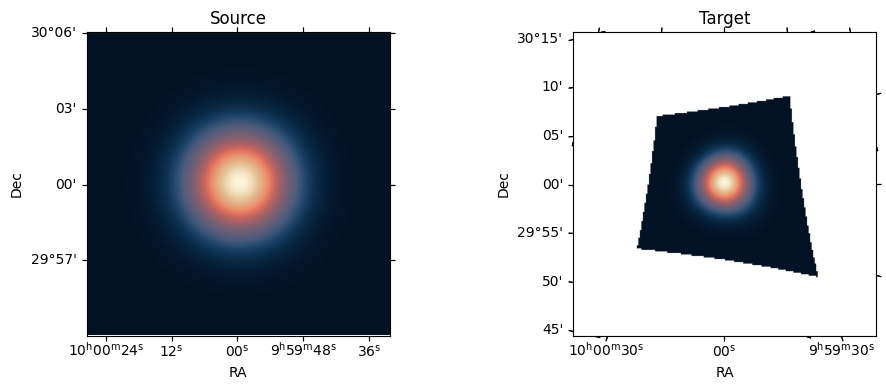

In [35]:
# Create two subplots, each with its own WCS projection
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 4),
    subplot_kw={'projection': wcs_source}  # default for first one
)

# Matplotlib reuses subplot_kw for *all* axes, so we’ll override the second manually
axs = axs.ravel()  # flatten in case it's a 2D array of axes

# First image with source WCS
axs[0].imshow(source_hdu.data, origin="lower", cmap=cmc.lipari)
axs[0].set_xlabel("RA")
axs[0].set_ylabel("Dec")
axs[0].set_title("Source")

# Second image with target WCS (must reset projection!)
# easiest: use fig.add_subplot directly
fig.delaxes(axs[1])  # remove placeholder axes
axs[1] = fig.add_subplot(122, projection=wcs_target)
axs[1].imshow(result.data.cpu(), origin="lower", cmap=cmc.lipari)
axs[1].set_xlabel("RA")
axs[1].set_ylabel("Dec")
axs[1].set_title("Target")

plt.tight_layout()
plt.show()

We see that the reprojection itself worked nicely, but let's check the flux conservation by computing the sum in the first image and comparing it to the sum in the reprojection. If flux is conserved, these should be approximately equal.

In [36]:
original_flux = source_hdu.data.sum()
interpolated_flux = np.nansum(result.data.cpu())

print(f'Original flux: {original_flux}')
print(f'Interpolated flux: {interpolated_flux}')
print(f'Relative Error: {(100*np.abs(original_flux - interpolated_flux) / original_flux):.2f}%')

Original flux: 314154.375
Interpolated flux: 314170.2412709008
Relative Error: 0.01%


As we can see the relative error is extremely low now.